In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import connectivity
from quetzal.io import excel

# Preparation of the transport network.
## Initialises a StepModel with parametrised zones.

In [3]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Initialising StepModel...
sm = stepmodel.StepModel(debug=False,
                         walk_on_road=False,
                         epsg=4326,
                         coordinates_unit=None)

Model zones are official administrative areas of Germany called "Gemeindeverbände". Geo-data is published under "Open Data Datenlizenz Deutschland – Namensnennung – Version 2.0"

Data source is: https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-250-000-ebenen-stand-01-01-vg250-ebenen-01-01.html

© GeoBasis-DE / BKG 2022

In [6]:
# Loading zones at level of "Gemeindeverband"
zones = gpd.read_file(input_path + 'administrative_zones_shapes/VG250_VWG.shp')
# Drop water areas and unused columns
zones = zones.loc[zones['GF']==4, ['ARS', 'NUTS', 'GEN', 'geometry']]
len(zones)

4605

In [7]:
# Update ARS codes to June 2022
zones.loc[zones['ARS']=='160560000', 'ARS'] = '160630105' # Eisenach
zones.loc[zones['ARS']=='031530007', 'ARS'] = '031530019' # Langelsheim
zones.loc[zones['ARS']=='032565405', 'ARS'] = '032565411' # Liebenau, Marklohe
zones.loc[zones['ARS']=='032565406', 'ARS'] = '032565412' # Liebenau, Marklohe
zones.loc[zones['ARS']=='120730532', 'ARS'] = '120735051' # Schwedt/Oder
# Bastheim is part of Mellrichstadt
zones.loc[zones['ARS']=='096730116', 'ARS'] = '096735633'
zones.loc[zones['ARS']=='096735633', 'geometry'] = zones.loc[zones['ARS']=='096735633', 'geometry'].unary_union
zones = zones.loc[zones['GEN']!='Bastheim']
# Neuhardenberg is part of Seelow-Land
zones.loc[zones['ARS']=='120645410', 'ARS'] = '120645412'
zones.loc[zones['ARS']=='120645412', 'geometry'] = zones.loc[zones['ARS']=='120645412', 'geometry'].unary_union
zones = zones.loc[zones['GEN']!='Neuhardenberg']

In [8]:
# Add them to the model
sm.zones = zones
sm.zones.columns = ['ARS', 'NUTS_ID', 'name', 'geometry']
sm.zones['ARS'] = sm.zones['ARS'].astype(int)
sm.zones.set_index('ARS', drop=False, inplace=True)
sm.zones.index.name = None
sm.zones.sample()

,ARS,NUTS_ID,name,geometry
120665606,120665606,DE40B,Ortrand,"POLYGON ((3833394.087 5713311.986, 3833442.105..."


In [9]:
# Set the CRS to the model CRS
sm.zones = sm.zones.to_crs(epsg=4326)

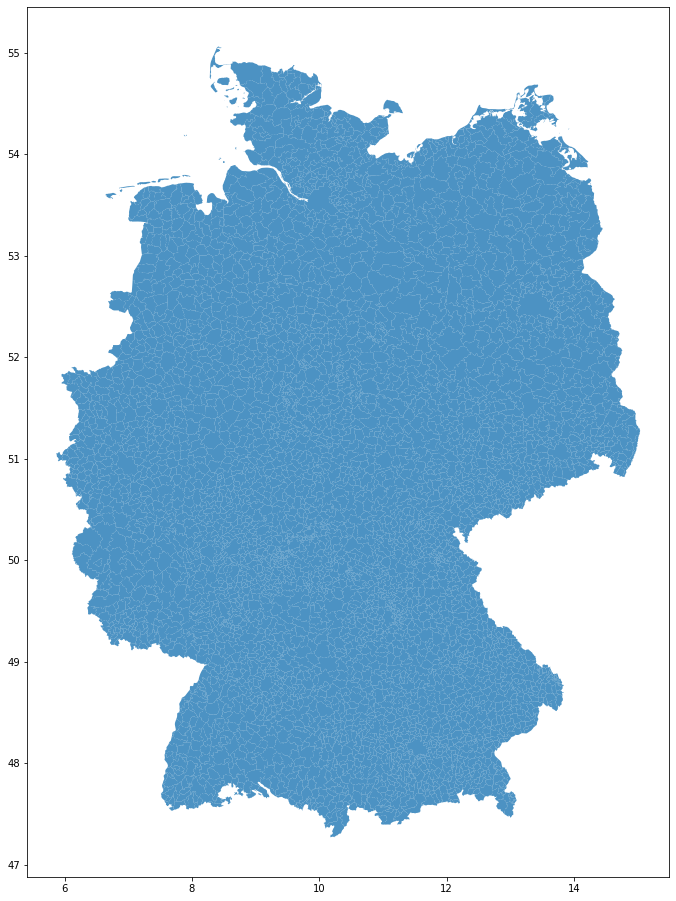

In [10]:
if manual:
    sm.zones.plot(alpha=.8, figsize=(16,16))

### Get zone data

Data for administrative zones in Germany is published under "Open Data Datenlizenz Deutschland – Namensnennung – Version 2.0"

Data source is: https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/_inhalt.html

© GeoBasis-DE / BKG 2022

In [11]:
# Load
col_names =['level_code', 'type_code', 'ARS_Land', 'ARS_RB', 'ARS_Kreis',
            'ARS_VB', 'ARS_Gem', 'name', 'area', 'date', 'population',
            'pop_male', 'pop_female', 'pop_density', 'zip_code', 'lat',
            'lon', 'travel_area_key', 'travel_area_name',
            'urbanisation_key', 'urbanisation_name']
zone_data = pd.read_excel(input_path + 'zone_data.xlsx', sheet_name='Onlineprodukt_Gemeinden',
                          decimal=',', thousands=' ', header=5, skipfooter=12,
                          names=col_names, na_filter=False)

In [12]:
# Drop "Kreis"-level and outer-German zones
zone_data = zone_data.loc[(zone_data['ARS_VB']!='') & (zone_data['ARS_VB']!='9999')]
len(zone_data)

15590

In [13]:
# Create FID
zone_data['ARS'] = (zone_data['ARS_Land'].astype(str) + zone_data['ARS_RB']
                    + zone_data['ARS_Kreis'] + zone_data['ARS_VB']).astype(int)

In [14]:
# Fill values at "Gemeindeverbands"-level
cols = ['area', 'population', 'zip_code', 'lat', 'lon', 'urbanisation_key']
types = [np.float64, np.int64, str, np.float64, np.float64, np.int64]
zone_data = zone_data.loc[zone_data['ARS_Gem']!='', cols+['ARS']
                         ].astype(dict(zip(cols, types))).groupby('ARS').agg({
    'area': 'sum',
    'population': 'sum',
    'zip_code': tuple,
    'lat': 'mean',
    'lon': 'mean',
    'urbanisation_key': 'mean'
})
len(zone_data)

4600

In [15]:
zone_data.rename(columns={'urbanisation_key':'urbanisation'}, inplace=True)
zone_data['urbanisation'] = zone_data['urbanisation'].apply(lambda u: int(u)).astype(int)
zone_data.sample()

,area,population,zip_code,lat,lon,urbanisation
ARS,,,,,,
53340012,75.75,56172,"(52249,)",6.266781,50.817431,2


In [16]:
len(zone_data.loc[zone_data['population']==0])

204

In [17]:
# Add attributes to zones table
for col in zone_data.columns:
    sm.zones[col] = sm.zones['ARS'].map(zone_data[col])
# Fill default values for missing zones
sm.zones.loc[sm.zones['area'].isna(), 'area'] = 0
sm.zones.loc[sm.zones['population'].isna(), 'population'] = 0
sm.zones.loc[sm.zones['zip_code'].isna(), 'zip_code'] = [
    (0,) for _ in range(len(sm.zones.loc[sm.zones['zip_code'].isna()]))]
sm.zones.loc[sm.zones['lat'].isna(), 'lat'] = [
    g.centroid.coords[0][0] for g in sm.zones.loc[sm.zones['lat'].isna(), 'geometry']]
sm.zones.loc[sm.zones['lon'].isna(), 'lon'] = [
    g.centroid.coords[0][1] for g in sm.zones.loc[sm.zones['lon'].isna(), 'geometry']]
sm.zones.loc[sm.zones['urbanisation'].isna(), 'urbanisation'] = 3
sm.zones.loc[sm.zones.isna().any(axis=1)]

,ARS,NUTS_ID,name,geometry,area,population,zip_code,lat,lon,urbanisation


<AxesSubplot:>

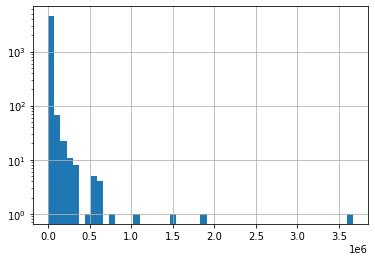

In [18]:
sm.zones['population'].hist(bins=50, log=True)

<AxesSubplot:>

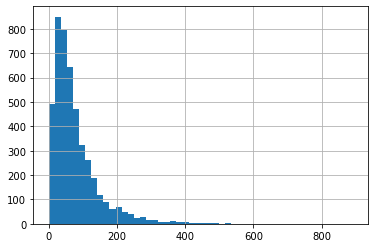

In [19]:
sm.zones['area'].hist(bins=50)

### Cluster zones

Use agglomerative clustering in order to reduce the number of small zones

In [20]:
# Use quetzal's node clustering function
# Cluster zones only within NUTS3-zones
dist_col = 'dist'
nuts_zones = gpd.GeoSeries(sm.zones.groupby('NUTS_ID').apply(lambda g: g['geometry'].unary_union.buffer(1e-3)))
cluster_zones = gpd.GeoDataFrame(data={dist_col: nuts_zones.area ** 0.5 * params['zones']['radius_share']},
                                 index=nuts_zones.index,
                                 geometry=list(nuts_zones))
clustered = connectivity.adaptive_clustering(nodes=gpd.GeoDataFrame(sm.zones[['ARS']],
                                                        geometry=sm.zones.centroid),
                                             zones=cluster_zones,
                                             distance_col=dist_col)

Mean distance threshold is 0


In [21]:
# Number of zones
len(clustered['adaptive_cluster_id'].unique())

2227

In [22]:
# Aggregate zones
sm.zones['cluster_id'] = clustered['adaptive_cluster_id']
sm.zones = gpd.GeoDataFrame(sm.zones.groupby('cluster_id').agg({
    'NUTS_ID': 'first',
    'ARS': tuple,
    'name': tuple,
    'area': 'sum',
    'population': 'sum',
    'lat': 'mean',
    'lon': 'mean',
    'urbanisation': 'mean',
    'geometry': lambda g: g.unary_union
}))

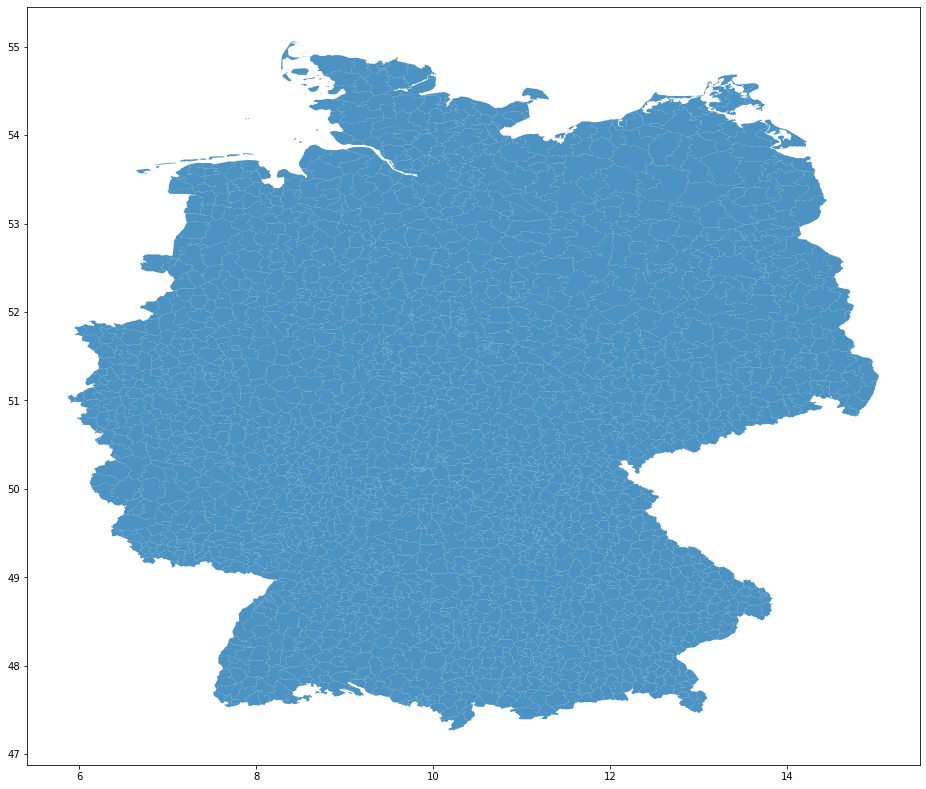

In [23]:
if manual:
    sm.zones.plot(alpha=.8, figsize=(16,16))

In [24]:
# Manage attributes
sm.zones['urbanisation'] = sm.zones['urbanisation'].astype(int)
sm.zones['population'] = sm.zones['population'].astype(int)
sm.zones['pop_share'] = sm.zones['population'] / sm.zones['NUTS_ID'].map(
    sm.zones.groupby('NUTS_ID')['population'].sum())
sm.zones['FID'] = sm.zones.index
sm.zones.head(3)

,NUTS_ID,ARS,name,area,population,lat,lon,urbanisation,geometry,pop_share,FID
cluster_id,,,,,,,,,,,
DE111_0,DE111,"(81110000,)","(Stuttgart,)",207.32,630305,9.177734,48.775817,1,"POLYGON ((9.22518 48.86601, 9.22500 48.86485, ...",1.000000,DE111_0
DE112_0,DE112,"(81150003, 81150045, 81155004)","(Böblingen, Sindelfingen, Holzgerlingen)",132.87,136175,9.000332,48.675150,1,"POLYGON ((9.02864 48.65663, 9.03167 48.65507, ...",0.346591,DE112_0
DE112_1,DE112,"(81155003, 81155005)","(Herrenberg, Oberes Gäu)",154.02,68243,8.831605,48.585037,2,"POLYGON ((8.75145 48.60227, 8.75451 48.60278, ...",0.173691,DE112_1


In [25]:
# Correct north sea islands
# Delete islands without population
sm.zones = sm.zones.loc[~(sm.zones['name'].apply(lambda l: l[0]=='Insel Lütje Hörn'))]
# Merge Sylt to one zone
sylt = sm.zones.loc[sm.zones['name'].apply(lambda l: sum(['Sylt' in s for s in l])>0)]
to_drop = sylt.index
sm.zones.loc['DEF07_99'] = {'NUTS_ID': 'DEF07', 'ARS': sylt['ARS'].sum(),
                            'name': ('Sylt',), 'area': sylt['area'].sum(),
                            'population': sylt['population'].sum(),
                            'lat': 8.308750, 'lon': 54.907860, 'urbanisation': 2,
                            'geometry': sylt['geometry'].unary_union,
                            'pop_share': sylt['population'].sum() / sm.zones.loc[
                                sm.zones['NUTS_ID']=='DEF07', 'population'].sum(),
                            'FID': 'DEF07_99'}
sm.zones.drop(to_drop, inplace=True)
len(sm.zones)

2225

### Save model

In [27]:
# Saving model zones as geojson
sm.to_json(model_path + scenario + '/' + 'de_zones',
           only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.89it/s]
